In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from pprint import pprint
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import (r2_score, accuracy_score, precision_score, 
                             confusion_matrix, recall_score, f1_score, roc_auc_score)
from sklearn.linear_model import LinearRegression
import pickle

In [2]:
from constants import *
from utils import DirectoryManager, FileDownloader

In [3]:
directory_manager = DirectoryManager("data")
file_downloader = FileDownloader(directory_manager)

file_downloader.download_files(urls_wget, urls_gdown)

All files are already downloaded


In [4]:
georgia_reciddf = pd.read_csv('data/georgia_recidivism.csv')
georgia_reciddf = georgia_reciddf.drop(columns="id") 

In [5]:
shape_dict = {
    "1_original shape": georgia_reciddf.shape,
    "2_count of null values": georgia_reciddf.isna().sum().sum(),
    "3_no. of duplicates": georgia_reciddf.duplicated().sum(),
    "4_shape after removing duplication and nan": georgia_reciddf.dropna().drop_duplicates().shape,
}
pprint(shape_dict)

{'1_original shape': (25835, 53),
 '2_count of null values': 36700,
 '3_no. of duplicates': 0,
 '4_shape after removing duplication and nan': (14170, 53)}


In [6]:
columns_with_nan = georgia_reciddf.columns[georgia_reciddf.isna().any()].tolist()
columns_with_nan

['gang_affiliated',
 'supervision_risk_score_first',
 'supervision_level_first',
 'prison_offense',
 'avg_days_per_drugtest',
 'drugtests_thc_positive',
 'drugtests_cocaine_positive',
 'drugtests_meth_positive',
 'drugtests_other_positive',
 'percent_days_employed',
 'jobs_per_year']

In [7]:
georgia_reciddf[columns_with_nan].isna().sum().sort_values(ascending=False)

avg_days_per_drugtest           6103
drugtests_thc_positive          5172
drugtests_cocaine_positive      5172
drugtests_meth_positive         5172
drugtests_other_positive        5172
prison_offense                  3277
gang_affiliated                 3167
supervision_level_first         1720
jobs_per_year                    808
supervision_risk_score_first     475
percent_days_employed            462
dtype: int64

In [8]:
columns_with_nan_numerical = georgia_reciddf[columns_with_nan].select_dtypes(include=[float, int]).columns.tolist()
columns_with_nan_categorical = georgia_reciddf[columns_with_nan].select_dtypes(include=[object, bool]).columns.tolist()

In [9]:
imputer_numerical = SimpleImputer(strategy='mean')
imputer_numerical.fit(georgia_reciddf[columns_with_nan_numerical])
georgia_reciddf[columns_with_nan_numerical] = imputer_numerical.fit_transform(georgia_reciddf[columns_with_nan_numerical])

In [10]:
imputer_categorical = SimpleImputer(strategy='most_frequent')
imputer_categorical.fit(georgia_reciddf[columns_with_nan_categorical])
georgia_reciddf[columns_with_nan_categorical] = imputer_categorical.fit_transform(georgia_reciddf[columns_with_nan_categorical])

In [11]:
georgia_reciddf["gang_affiliated"] = georgia_reciddf["gang_affiliated"].astype(int)

In [12]:
bool_features = georgia_reciddf.select_dtypes(include=bool).columns.tolist()

nominal_features = ['gender', 'prison_offense', 'race']

ordinal_features = ["age_at_release", "supervision_level_first",
                     "education_level", "dependents", "prison_years", "prior_arrest_episodes_felony",
                     "prior_arrest_episodes_misd", "prior_arrest_episodes_violent", "prior_arrest_episodes_property",
                     "prior_arrest_episodes_drug", "prior_arrest_episodes", "prior_conviction_episodes",
                     "prior_conviction_episodes_1", "prior_conviction_episodes_3", "prior_conviction_episodes_4",
                     "delinquency_reports", "program_attendances", "program_unexcusedabsences", "residence_changes"]

In [13]:
# Check if the combined set of nominal and ordinal features is the same to the set of object and bool columns in georgia_reciddf
set(nominal_features + ordinal_features) == set(georgia_reciddf.select_dtypes(include=object).columns)

True

<h1> Transformations

<h2> Bool Features

In [14]:
georgia_reciddf[bool_features] = georgia_reciddf[bool_features].astype(int)

<h2> Nominal Features

In [15]:
unique_nominal_dict = {}
for feature in nominal_features:
    unique_nominal_dict[feature] = georgia_reciddf[feature].unique().tolist()
pprint(unique_nominal_dict)

{'gender': ['M', 'F'],
 'prison_offense': ['Drug',
                    'Violent/Non-Sex',
                    'Property',
                    'Other',
                    'Violent/Sex'],
 'race': ['BLACK', 'WHITE']}


In [16]:
ohe = OneHotEncoder()
feature_array = ohe.fit_transform(georgia_reciddf[nominal_features]).toarray()

feature_labels = []
for category in ohe.categories_:
    feature_labels.extend(list(category)) 
feature_labels

['F',
 'M',
 'Drug',
 'Other',
 'Property',
 'Violent/Non-Sex',
 'Violent/Sex',
 'BLACK',
 'WHITE']

In [17]:
df = pd.DataFrame(feature_array, columns=feature_labels)
df.sample(5)

,F,M,Drug,Other,Property,Violent/Non-Sex,Violent/Sex,BLACK,WHITE
7853,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
5849,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
13347,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
23247,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
664,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [18]:
cols_to_drop = ["F", "Other", "BLACK"]
df = df.drop(columns=cols_to_drop)
df.head()

,M,Drug,Property,Violent/Non-Sex,Violent/Sex,WHITE
0,1.0,1.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,1.0,0.0,0.0
2,1.0,1.0,0.0,0.0,0.0,0.0
3,1.0,0.0,1.0,0.0,0.0,1.0
4,1.0,0.0,0.0,1.0,0.0,1.0


In [19]:
georgia_reciddf = georgia_reciddf.drop(nominal_features, axis=1)
georgia_reciddf = pd.concat([georgia_reciddf, df], axis=1)
georgia_reciddf.head()

,age_at_release,residence_puma,gang_affiliated,supervision_risk_score_first,supervision_level_first,education_level,dependents,prison_years,prior_arrest_episodes_felony,prior_arrest_episodes_misd,...,recidivism_arrest_year1,recidivism_arrest_year2,recidivism_arrest_year3,training_sample,M,Drug,Property,Violent/Non-Sex,Violent/Sex,WHITE
0,43-47,16,0,3.0,Standard,At least some college,3 or more,More than 3 years,6,6 or more,...,0,0,0,1,1.0,1.0,0.0,0.0,0.0,0.0
1,33-37,16,0,6.0,Specialized,Less than HS diploma,1,More than 3 years,7,6 or more,...,0,0,1,1,1.0,0.0,0.0,1.0,0.0,0.0
2,48 or older,24,0,7.0,High,At least some college,3 or more,1-2 years,6,6 or more,...,0,1,0,1,1.0,1.0,0.0,0.0,0.0,0.0
3,38-42,16,0,7.0,High,Less than HS diploma,1,1-2 years,8,6 or more,...,0,0,0,1,1.0,0.0,1.0,0.0,0.0,1.0
4,33-37,16,0,4.0,Specialized,Less than HS diploma,3 or more,1-2 years,4,4,...,1,0,0,1,1.0,0.0,0.0,1.0,0.0,1.0


<h2> Ordinal Features

In [20]:
unique_ordinal_dict = {}
for feature in ordinal_features:
    unique_ordinal_dict[feature] = georgia_reciddf[feature].unique().tolist()
pprint(unique_ordinal_dict)

{'age_at_release': ['43-47',
                    '33-37',
                    '48 or older',
                    '38-42',
                    '18-22',
                    '23-27',
                    '28-32'],
 'delinquency_reports': ['0', '4 or more', '3', '2', '1'],
 'dependents': ['3 or more', '1', '0', '2'],
 'education_level': ['At least some college',
                     'Less than HS diploma',
                     'High School Diploma'],
 'prior_arrest_episodes': ['4', '5 or more', '3', '0', '1', '2'],
 'prior_arrest_episodes_drug': ['3', '2', '1', '0', '5 or more', '4'],
 'prior_arrest_episodes_felony': ['6',
                                  '7',
                                  '8',
                                  '4',
                                  '10 or more',
                                  '3',
                                  '9',
                                  '2',
                                  '5',
                                  '1',
              

In [21]:
features_with_corresponding_order = {
    'education_level': ['Less than HS diploma', 'High School Diploma', 'At least some college'],
    'prison_years': ['1-2 years', 'Less than 1 year', 'Greater than 2 to 3 years', 'More than 3 years'],
    'supervision_level_first': ['Standard', 'High', 'Specialized'],
    'program_attendances': ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10 or more'],
    'prior_arrest_episodes_felony': ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10 or more']
}
for feature in ordinal_features:
    if not (feature in features_with_corresponding_order.keys()):
        features_with_corresponding_order[feature] = sorted(unique_ordinal_dict[feature], key=lambda x: int(x[0]))

pprint(features_with_corresponding_order)

{'age_at_release': ['18-22',
                    '23-27',
                    '28-32',
                    '33-37',
                    '38-42',
                    '43-47',
                    '48 or older'],
 'delinquency_reports': ['0', '1', '2', '3', '4 or more'],
 'dependents': ['0', '1', '2', '3 or more'],
 'education_level': ['Less than HS diploma',
                     'High School Diploma',
                     'At least some college'],
 'prior_arrest_episodes': ['0', '1', '2', '3', '4', '5 or more'],
 'prior_arrest_episodes_drug': ['0', '1', '2', '3', '4', '5 or more'],
 'prior_arrest_episodes_felony': ['0',
                                  '1',
                                  '2',
                                  '3',
                                  '4',
                                  '5',
                                  '6',
                                  '7',
                                  '8',
                                  '9',
                       

In [22]:
# Encoding Categorical Variables
for feature in ordinal_features:
    enc = OrdinalEncoder(categories=[features_with_corresponding_order[feature]])
    georgia_reciddf[[feature]] = enc.fit_transform(georgia_reciddf[[feature]])

## V) **Regression Analysis**

In [23]:
regression_columns = ['WHITE', 'age_at_release', 'gang_affiliated', 'prior_conviction_episodes',
                    'prior_conviction_episodes_1', 'prior_conviction_episodes_2',
                    'prior_conviction_episodes_3', 'prior_conviction_episodes_4',
                    'prior_conviction_episodes_5', 'prior_conviction_episodes_6',
                    'prior_conviction_episodes_7', 'supervision_risk_score_first']

df_regression = georgia_reciddf.copy()[regression_columns]

In [24]:
shape_dict = {
    "1_original shape": df_regression.shape,
    "2_count of null values": df_regression.isna().sum().sum(),
    "3_no. of duplicates": df_regression.duplicated().sum(),
    "4_shape after removing duplication and nan": df_regression.dropna().drop_duplicates().shape,
}
pprint(shape_dict)

{'1_original shape': (25835, 12),
 '2_count of null values': 0,
 '3_no. of duplicates': 7830,
 '4_shape after removing duplication and nan': (18005, 12)}


In [25]:
df_regression = df_regression.groupby(df_regression.columns.tolist(), as_index=False).mean()
df_regression.shape

(18005, 12)

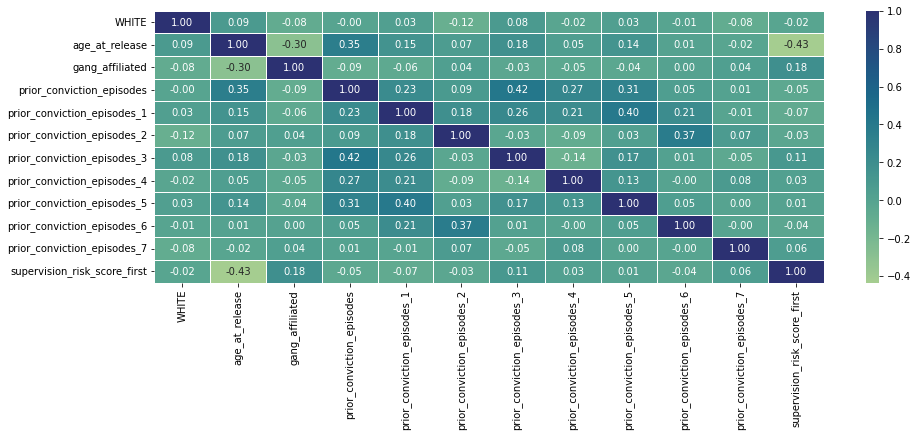

In [26]:
# Exploratory Data Analysis
plt.figure(figsize=(15, 5))
sns.heatmap(df_regression.corr(), annot=True, fmt=".2f", linewidth=.5, cmap="crest");

In [27]:
# Model Fitting
X, y = df_regression.drop('supervision_risk_score_first', axis=1), df_regression['supervision_risk_score_first']

# Standardizing the data using StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Linear regression
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Predictions
y_train_pred = linear_model.predict(X_train)
y_test_pred = linear_model.predict(X_test)

# Model evaluation
print("Training R2:", r2_score(y_train, y_train_pred))
print("Test R2:", r2_score(y_test, y_test_pred))

Training R2: 0.24870531231493498
Test R2: 0.2440199204639366


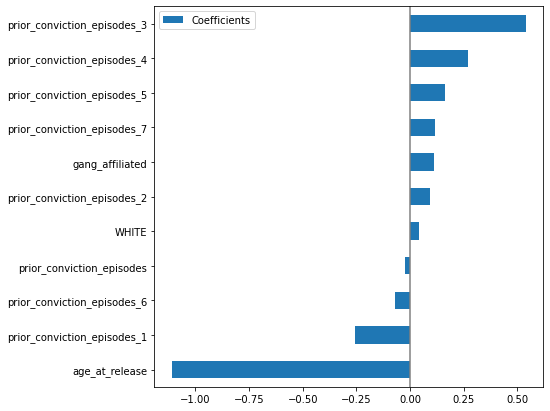

In [28]:
coefs = pd.DataFrame(
    linear_model.coef_, columns=["Coefficients"], index=X.columns
).sort_values(by="Coefficients")

coefs.plot(kind="barh", figsize=(9, 7))
plt.axvline(x=0, color=".5")
plt.subplots_adjust(left=0.3)

# VI) ML clf

In [29]:
# Combine Data Preprocessing Steps
X, y = georgia_reciddf.drop(columns='recidivism_within_3years'), georgia_reciddf['recidivism_within_3years']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [30]:
# Check for imbalance in the training, and test sets
print("Class distribution in training set:")
print(y_train.value_counts(normalize=True))
print()
print("Class distribution in test set:")
print(y_test.value_counts(normalize=True))

Class distribution in training set:
1    0.576592
0    0.423408
Name: recidivism_within_3years, dtype: float64

Class distribution in test set:
1    0.578092
0    0.421908
Name: recidivism_within_3years, dtype: float64


In [31]:
# Baseline
baseline = y.value_counts(normalize=True).max()
print(f"Baseline: {baseline * 100:.2f}%")

Baseline: 57.69%


In [32]:
# load the model from disk
filename = "Models/Model_1.sav"
loaded_model = pickle.load(open(filename, 'rb'))

best_params = loaded_model.best_params_

# Use the best estimator to make predictions on the training set
y_train_pred = loaded_model.best_estimator_.predict(X_train)
accuracy_train = accuracy_score(y_train, y_train_pred)

# Predict on the test set using the best parameters
y_pred_test = loaded_model.predict(X_test)
accuracy_test = accuracy_score(y_test, y_pred_test)

print("Best Parameters: ", best_params)
print("Accuracy on the training set: ", accuracy_train)
print("Accuracy on the test set: ", accuracy_test)

Best Parameters:  {'pca__n_components': 20, 'classifier__n_estimators': 100, 'classifier__min_samples_split': 5, 'classifier__max_depth': 30}
Accuracy on the training set:  0.9995645442229534
Accuracy on the test set:  0.9711631507644668


In [33]:
# Confusion matrix on the test set
other_metrics = {
    "1_Confusion Matrix": list(confusion_matrix(y_test, y_pred_test)),
    "2_Precision": precision_score(y_test, y_pred_test),
    "3_Recall": recall_score(y_test, y_pred_test),
    "4_AUC-ROC Score": roc_auc_score(y_test, loaded_model.best_estimator_.predict_proba(X_test)[:, 1])
}
pprint(other_metrics)

{'1_Confusion Matrix': [array([2075,  105], dtype=int64),
                        array([  44, 2943], dtype=int64)],
 '2_Precision': 0.9655511811023622,
 '3_Recall': 0.9852695011717443,
 '4_AUC-ROC Score': 0.9963318109360746}


In [34]:
# Load the model from the file
with open("Models/Model_2.sav", "rb") as file:
    model_2 = pickle.load(file)

best_params = model_2.best_params_

# Use the best estimator to make predictions on the training set
y_train_pred = model_2.best_estimator_.predict(X_train)
accuracy_train = accuracy_score(y_train, y_train_pred)

# Predict on the test set using the best parameters
y_pred_test = model_2.predict(X_test)
accuracy_test = accuracy_score(y_test, y_pred_test)

print("Best Parameters: ")
pprint(best_params)
print("Accuracy on the training set: ", accuracy_train)
print("Accuracy on the test set: ", accuracy_test)

Best Parameters: 
{'classifier__max_depth': 20,
 'classifier__n_estimators': 5,
 'pca__n_components': 20}
Accuracy on the training set:  0.9851461196051867
Accuracy on the test set:  0.9254886781497967


In [35]:
# Load the model from the file
with open("Models/Model_3.sav", "rb") as file:
    model_3 = pickle.load(file)

best_params = model_3.best_params_

# Use the best estimator to make predictions on the training set
y_train_pred = model_3.best_estimator_.predict(X_train)
accuracy_train = accuracy_score(y_train, y_train_pred)

# Predict on the test set using the best parameters
y_pred_test = model_3.predict(X_test)
accuracy_test = accuracy_score(y_test, y_pred_test)

print("Best Parameters: ")
pprint(best_params)
print("Accuracy on the training set: ", accuracy_train)
print("Accuracy on the test set: ", accuracy_test)

Best Parameters: 
{'classifier__max_depth': 20,
 'classifier__min_samples_split': 2,
 'umap__n_components': 20,
 'umap__n_neighbors': 30}
Accuracy on the training set:  1.0
Accuracy on the test set:  0.9328430423843623
